In [1]:
import math
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from datetime import datetime as dt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.feature_selection import SelectKBest
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from scipy import stats as sc
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score
from numpy import log
from sklearn.feature_selection import RFECV
from sklearn.base import clone
import pickle

Using TensorFlow backend.


In [2]:
class SFS():
    def __init__(self, estimator, k_features, metric="accuracy", test_size=0.25, cv=5, classification = True, random_state=1):
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.cv = cv
        self.metric = metric
        self.classification = classification
        self.random_state = random_state
    def fit(self, X, y):   
        if self.metric == "bic":
            calc_score = self._bic_calc_score
        elif self.metric == "cv":
            calc_score = self._cv_calc_score
        else:
            calc_score = self._accuracy_calc_score
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        dim = 0
        options = list(range(X_train.shape[1]))
        self.indices_ = []
        self.subsets_ = []
        self.scores_ = []
        self.test_scores_ = []
        while dim < self.k_features:
            print('Processing:', dim)
            scores, subsets, test_scores = [], [], []
            comb=[]
            for opt in options:
                comb.append(self.indices_+[opt])
#             print(comb)
            for p in comb:
                score = calc_score(X_train, y_train, X_test, y_test, p)
                test_score = self._accuracy_calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                test_scores.append(test_score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            options.remove(subsets[best][-1])
            self.subsets_.append(self.indices_)
            dim += 1
            self.scores_.append(scores[best])
            self.test_scores_.append(test_scores[best])
        self.k_score_ = self.scores_[-1]
        self.subsets_ = [tuple(x) for x in self.subsets_]
        return self
    def transform(self, X):
        return X[:, self.indices_]
    def _accuracy_calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = accuracy_score(y_test, y_pred)
        return score
    def _cv_calc_score(self, X_train, y_train, X_test, y_test, indices):
        cv_scores = cross_val_score(self.estimator, X_train[:, indices], y_train, cv=self.cv, n_jobs=-1)
        score = np.mean(cv_scores)
        return score
    def _bic_calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        if self.classification:
            sse = np.sum(y_pred != y_test)
        else:
            sse = sum((y_test - y_pred)**2)
        n = len(X_test)
        k = len(indices)
        bic = n*log(sse/n) + k*log(n)
        return -(bic)
    

def plotSFS(sfs):
    k_feat = [len(k) for k in sfs.subsets_]
    plt.figure(1, (9,6))
    plt.plot(k_feat, sfs.test_scores_, marker='o', color='orange', label = 'Test set score')
    if sfs.metric == 'cv':
        plt.plot(k_feat, sfs.scores_, marker='o', color='deepskyblue', label = str(sfs.cv) + '-fold CV score')
    plt.ylim([0.0, 1.02])
    plt.ylabel('Accuracy')
    plt.xlabel('Number of features')
    plt.grid()
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()
    for idx, subs in enumerate(sfs.subsets_):
        print(str(len(subs))+' feature(s):', sorted(subs), ' Metric Score:', sfs.scores_[idx], ' Test Score:', sfs.test_scores_[idx])

In [3]:
def plot_corr(df,size=10):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr)
    fig.colorbar(cax)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)
    
def rfFeaturePlot(rf_reg, col_list, plot=True, title="Feature importances"):
    importances = rf_reg.feature_importances_

    std = np.std([tree.feature_importances_ for tree in rf_reg.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    if plot:
        # Plot the feature importances of the forest
        plt.figure(1,(15,9))
        plt.title(title)
        plt.bar(range(rf_reg.n_features_), importances[indices],  
               color="r", align="center")
        plt.xticks(range(rf_reg.n_features_),col_list[indices], rotation='vertical', fontsize=15)
#         plt.xlim([-1,rf_reg.n_features_)
        plt.xlim([-1, 20.5])
        plt.ylabel('Relative Importance')
        plt.show()
        
def variance_threshold_selector(data, threshold=0.7):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

def kBestSelector(data, y, score_func = chi2, k = 5):
    selector = SelectKBest(score_func, k = k).fit(data, y)
    return data[data.columns[selector.get_support(indices=True)]]

def plotPca(pca, Xtrain):
    plt.figure(1,(8,6))
    plt.bar(range(1, Xtrain.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, align='center')
    plt.step(range(1, Xtrain.shape[1]+1), np.cumsum(pca.explained_variance_ratio_), where='mid')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.xlim([0, 300])
    plt.show()
    
def get_important_features(transformed_features, components_, columns):
    num_columns = len(columns)

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])
    
    # Sort each column by it's length. These are your *original*
    # columns, not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print("Features by importance:\n", important_features)
def cvKBestSelector(X, y, model, scaler = None, testSize = 0.25, cv = 5, random_state = 20191027):
    result_dict = {}
    for k_v in range(1, X.shape[1]+1):
        X_ked = kBestSelector(X, y, score_func = chi2, k = k_v)
        X_train, X_test, y_train, y_test = train_test_split(X_ked, y, test_size=testSize, random_state=random_state)
        if scaler != None:
            scaler = scaler
            X_train = scaler.fit_transform(X_train.values)
            X_test = scaler.transform(X_test.values)
        else:
            X_train, X_test = X_train.values, X_test.values
        loc_model = clone(model)
        loc_model.fit(X_train, y_train)
        cv_scores = cross_val_score(loc_model, X_train, y_train, cv=cv, n_jobs=-1)
        result_dict[k_v] = (cv_scores, loc_model.score(X_train, y_train), np.mean(cv_scores), loc_model.score(X_test, y_test))
    max = float("-inf")
    fn = 0
    for k,v in result_dict.items():
        if v[2] > max:
            fn = k
            max = v[2]
    print(fn, max)

    x_ax = []
    y_ax = []
    test_pred = []
    train_pred = []
    for k,v in result_dict.items():
        x_ax.append(k)
        train_pred.append(v[1])
        y_ax.append(v[2])
        test_pred.append(v[3])
    plt.figure(figsize=(12,9))
    plt.title('Score against number of features')
    plt.ylabel('Accuracy')
    plt.xlabel('n features')
    plt.plot(x_ax, y_ax, color='orange', label = str(cv) + '-fold CV score')
    plt.plot(x_ax, test_pred, color='deepskyblue', label = 'Testing score')
    plt.plot(x_ax, train_pred, color='red', label = 'Training score')
    plt.legend(loc='best')
    plt.show()

def cvPCA(X, y, model, testSize = 0.25, cv = 5, random_state = 20191027):
    result_dict = {}
    for k_v in range(1, X.shape[1]+1):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize, random_state=random_state)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train.values)
        X_test = scaler.transform(X_test.values)
        pca = PCA(n_components = k_v)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
        loc_model = clone(model)
        loc_model.fit(X_train, y_train)
        cv_scores = cross_val_score(loc_model, X_train, y_train, cv=cv, n_jobs=-1)
        result_dict[k_v] = (cv_scores, loc_model.score(X_train, y_train), np.mean(cv_scores), loc_model.score(X_test, y_test))
    max = float("-inf")
    fn = 0
    for k,v in result_dict.items():
        if v[2] > max:
            fn = k
            max = v[2]
    print(fn, max)

    x_ax = []
    y_ax = []
    test_pred = []
    train_pred = []
    for k,v in result_dict.items():
        x_ax.append(k)
        train_pred.append(v[1])
        y_ax.append(v[2])
        test_pred.append(v[3])
    plt.figure(figsize=(12,9))
    plt.title('Score against number of principal components')
    plt.ylabel('Accuracy')
    plt.xlabel('n PCA components')
    plt.plot(x_ax, y_ax, color='orange', label = str(cv) + '-fold CV score')
    plt.plot(x_ax, test_pred, color='deepskyblue', label = 'Testing score')
    plt.plot(x_ax, train_pred, color='red', label = 'Training score')
    plt.legend(loc='best')
    plt.show()

In [4]:
complete_season_path = "master_data_ver2/all_season_master_data.csv"
complete_season_df = pd.read_csv(complete_season_path)

In [106]:
complete_season_df.iloc[:,:30]

,match_id,date,home_team_name,away_team_name,winner,home_goal,away_goal,goal_difference,home_team_team_rating,home_team_att_goal_low_left,...,home_team_att_miss_right,home_team_att_sv_low_centre,home_team_aerial_lost,home_team_accurate_pass,home_team_total_pass,home_team_won_corners,home_team_shot_off_target,home_team_ontarget_scoring_att,home_team_goals,home_team_att_miss_left
0,829513,16/08/2014 17:30:00,Arsenal,Crystal Palace,1,2,1,1,7.149141,1.250000,...,1.896552,2.173913,16.789474,452.894737,540.157895,6.891892,5.578947,6.135135,2.151515,2.030303
1,829514,18/08/2014 20:00:00,Burnley,Chelsea,-1,1,3,-2,6.785846,1.000000,...,1.680000,1.400000,24.631579,252.157895,358.815789,4.621622,4.789474,3.378378,1.400000,1.827586
2,829515,16/08/2014 15:00:00,Leicester,Everton,0,2,2,0,6.843094,1.454545,...,1.750000,1.650000,28.157895,249.684211,351.184211,5.578947,5.621622,3.805556,1.916667,2.172414
3,829516,17/08/2014 13:30:00,Liverpool,Southampton,1,2,1,1,6.902160,1.153846,...,1.800000,1.680000,15.526316,422.105263,509.815789,5.210526,6.131579,5.052632,1.733333,2.241379
4,829517,16/08/2014 12:45:00,Manchester United,Swansea,-1,1,2,-1,6.990919,1.294118,...,1.666667,1.960000,15.526316,477.368421,560.763158,5.631579,5.081081,4.864865,2.066667,2.000000
5,829518,17/08/2014 16:00:00,Newcastle United,Manchester City,-1,0,2,-2,6.740591,1.272727,...,1.758621,1.550000,23.000000,303.684211,395.263158,5.842105,5.078947,3.864865,1.600000,2.172414
6,829519,16/08/2014 15:00:00,Queens Park Rangers,Hull,-1,0,1,-1,6.765569,1.333333,...,1.689655,1.535714,23.894737,254.342105,359.421053,4.710526,5.657895,3.947368,1.615385,2.419355
7,829520,16/08/2014 15:00:00,Stoke,Aston Villa,-1,0,1,-1,6.868352,1.083333,...,1.851852,1.650000,19.026316,313.473684,404.710526,5.270270,5.756757,3.578947,1.655172,2.370370
8,829521,16/08/2014 15:00:00,West Bromwich Albion,Sunderland,0,2,2,0,6.765031,1.076923,...,1.666667,1.636364,17.000000,284.947368,379.842105,4.777778,4.552632,3.666667,1.520000,1.851852
9,829522,16/08/2014 15:00:00,West Ham,Tottenham,-1,0,1,-1,6.854401,1.076923,...,2.033333,1.523810,19.473684,266.342105,357.000000,6.513514,5.297297,4.108108,1.629630,2.093750


In [222]:
data_df = complete_season_df.drop(columns=['match_id', 'date', 'home_team_name', 'away_team_name'])
X_unp = data_df.iloc[:,4:]
y = data_df.iloc[:,0]

In [223]:
X_unp.shape, y.shape

((1520, 938), (1520,))

# Data Preprocess

In [244]:
X = variance_threshold_selector(X_unp, 0.7)
X.shape

(1520, 342)

In [110]:
# X = kBestSelector(X, y, score_func = chi2, k = 41)

In [111]:
X.columns

Index(['home_team_won_contest', 'home_team_possession_percentage',
       'home_team_total_throws', 'home_team_blocked_scoring_att',
       'home_team_total_scoring_att', 'home_team_total_tackle',
       'home_team_aerial_won', 'home_team_att_miss_right',
       'home_team_aerial_lost', 'home_team_accurate_pass',
       ...
       'away_player_11_player_rating', 'away_player_11_touches',
       'away_player_11_total_pass', 'away_player_11_aerial_won',
       'away_player_11_formation_place', 'away_player_11_accurate_pass',
       'away_player_11_aerial_lost', 'away_player_11_fouls',
       'away_player_11_total_scoring_att', 'away_player_11_won_contest'],
      dtype='object', length=366)

# Data splitting

In [225]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20191027)

In [226]:
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train.values)
X_test_std = stdsc.transform(X_test.values)

In [227]:
rbsc = RobustScaler()
X_train_rbs = rbsc.fit_transform(X_train.values)
X_test_rbs = rbsc.transform(X_test.values)

In [228]:
mm = MinMaxScaler()
X_train_mm = mm.fit_transform(X_train.values)
X_test_mm = mm.transform(X_test.values)

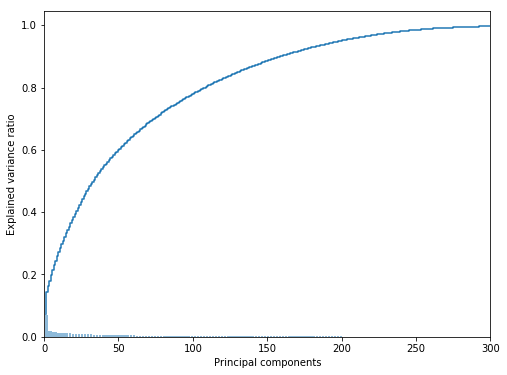

In [243]:
pca = PCA(n_components = 300)
X_train = pca.fit_transform(X_train_std)
X_test = pca.transform(X_test_std)
plotPca(pca, X_train)

# Modeling

In [230]:
# team_pred_model = LogisticRegression(penalty='l2', C=0.07, solver = 'lbfgs', multi_class='multinomial', n_jobs=-1, max_iter = 80000, random_state=20191028)
# sfs = SFS(team_pred_model, k_features=3, metric = 'cv')
# sfs.fit(X_train_std, y_train)
# plotSFS(sfs)

In [232]:
estimator = LogisticRegression(penalty='l2', C=0.07, solver = 'lbfgs', multi_class='multinomial', n_jobs=-1, max_iter = 80000, random_state=20191028)
selector = RFECV(estimator, step=1, cv=5, verbose = 1)
selector = selector.fit(X_train_rbs, y_train)
with open('pickle_models/rfecv_LogReg.pickle', 'wb') as handle:
    pickle.dump(selector, handle, protocol=pickle.HIGHEST_PROTOCOL)
sum(selector.support_)

Fitting estimator with 366 features.
Fitting estimator with 365 features.
Fitting estimator with 364 features.
Fitting estimator with 363 features.
Fitting estimator with 362 features.
Fitting estimator with 361 features.
Fitting estimator with 360 features.
Fitting estimator with 359 features.
Fitting estimator with 358 features.
Fitting estimator with 357 features.
Fitting estimator with 356 features.
Fitting estimator with 355 features.
Fitting estimator with 354 features.
Fitting estimator with 353 features.
Fitting estimator with 352 features.
Fitting estimator with 351 features.
Fitting estimator with 350 features.
Fitting estimator with 349 features.
Fitting estimator with 348 features.
Fitting estimator with 347 features.
Fitting estimator with 346 features.
Fitting estimator with 345 features.
Fitting estimator with 344 features.
Fitting estimator with 343 features.
Fitting estimator with 342 features.
Fitting estimator with 341 features.
Fitting estimator with 340 features.
F

Fitting estimator with 144 features.
Fitting estimator with 143 features.
Fitting estimator with 142 features.
Fitting estimator with 141 features.
Fitting estimator with 140 features.
Fitting estimator with 139 features.
Fitting estimator with 138 features.
Fitting estimator with 137 features.
Fitting estimator with 136 features.
Fitting estimator with 135 features.
Fitting estimator with 134 features.
Fitting estimator with 133 features.
Fitting estimator with 132 features.
Fitting estimator with 131 features.
Fitting estimator with 130 features.
Fitting estimator with 129 features.
Fitting estimator with 128 features.
Fitting estimator with 127 features.
Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.
Fitting estimator with 120 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.
F

Fitting estimator with 284 features.
Fitting estimator with 283 features.
Fitting estimator with 282 features.
Fitting estimator with 281 features.
Fitting estimator with 280 features.
Fitting estimator with 279 features.
Fitting estimator with 278 features.
Fitting estimator with 277 features.
Fitting estimator with 276 features.
Fitting estimator with 275 features.
Fitting estimator with 274 features.
Fitting estimator with 273 features.
Fitting estimator with 272 features.
Fitting estimator with 271 features.
Fitting estimator with 270 features.
Fitting estimator with 269 features.
Fitting estimator with 268 features.
Fitting estimator with 267 features.
Fitting estimator with 266 features.
Fitting estimator with 265 features.
Fitting estimator with 264 features.
Fitting estimator with 263 features.
Fitting estimator with 262 features.
Fitting estimator with 261 features.
Fitting estimator with 260 features.
Fitting estimator with 259 features.
Fitting estimator with 258 features.
F

Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 fe

Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
Fitting estimator with 186 features.
Fitting estimator with 185 features.
Fitting estimator with 184 features.
Fitting estimator with 183 features.
Fitting estimator with 182 features.
Fitting estimator with 181 features.
Fitting estimator with 180 features.
Fitting estimator with 179 features.
Fitting estimator with 178 features.
Fitting estimator with 177 features.
Fitting estimator with 176 features.
Fitting estimator with 175 features.
Fitting estimator with 174 features.
Fitting estimator with 173 features.
Fitting estimator with 172 features.
Fitting estimator with 171 features.
F

Fitting estimator with 337 features.
Fitting estimator with 336 features.
Fitting estimator with 335 features.
Fitting estimator with 334 features.
Fitting estimator with 333 features.
Fitting estimator with 332 features.
Fitting estimator with 331 features.
Fitting estimator with 330 features.
Fitting estimator with 329 features.
Fitting estimator with 328 features.
Fitting estimator with 327 features.
Fitting estimator with 326 features.
Fitting estimator with 325 features.
Fitting estimator with 324 features.
Fitting estimator with 323 features.
Fitting estimator with 322 features.
Fitting estimator with 321 features.
Fitting estimator with 320 features.
Fitting estimator with 319 features.
Fitting estimator with 318 features.
Fitting estimator with 317 features.
Fitting estimator with 316 features.
Fitting estimator with 315 features.
Fitting estimator with 314 features.
Fitting estimator with 313 features.
Fitting estimator with 312 features.
Fitting estimator with 311 features.
F

Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estim

Fitting estimator with 254 features.
Fitting estimator with 253 features.
Fitting estimator with 252 features.
Fitting estimator with 251 features.
Fitting estimator with 250 features.
Fitting estimator with 249 features.
Fitting estimator with 248 features.
Fitting estimator with 247 features.
Fitting estimator with 246 features.
Fitting estimator with 245 features.
Fitting estimator with 244 features.
Fitting estimator with 243 features.
Fitting estimator with 242 features.
Fitting estimator with 241 features.
Fitting estimator with 240 features.
Fitting estimator with 239 features.
Fitting estimator with 238 features.
Fitting estimator with 237 features.
Fitting estimator with 236 features.
Fitting estimator with 235 features.
Fitting estimator with 234 features.
Fitting estimator with 233 features.
Fitting estimator with 232 features.
Fitting estimator with 231 features.
Fitting estimator with 230 features.
Fitting estimator with 229 features.
Fitting estimator with 228 features.
F

Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 366 features.

Fitting estimator with 170 features.
Fitting estimator with 169 features.
Fitting estimator with 168 features.
Fitting estimator with 167 features.
Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.
Fitting estimator with 151 features.
Fitting estimator with 150 features.
Fitting estimator with 149 features.
Fitting estimator with 148 features.
Fitting estimator with 147 features.
Fitting estimator with 146 features.
Fitting estimator with 145 features.
Fitting estimator with 144 features.
F

6

In [233]:
f = selector.support_
team_pred_model = LogisticRegression(penalty='l2', C=0.07, solver = 'lbfgs', multi_class='multinomial', n_jobs=-1, max_iter = 80000, random_state=20191028)
team_pred_model.fit(X_train_rbs[:, f], y_train)
cv_scores = cross_val_score(team_pred_model, X_train_rbs[:, f], y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print('TRAINING Accuracy: %.3f' % team_pred_model.score(X_train_rbs[:, f], y_train))
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('TEST Accuracy: %.3f' % team_pred_model.score(X_test_rbs[:, f], y_test))

CV SCORES: [0.55021834 0.56331878 0.51965066 0.57709251 0.50442478]
TRAINING Accuracy: 0.546
Average 5-Fold Training CV Score: 0.5429410125400084
TEST Accuracy: 0.526


Processing: 0
3
Processing: 1
3
Processing: 2
3
Processing: 3
3
Processing: 4
3
Processing: 5
3
Processing: 6
3
Processing: 7
3
Processing: 8
3
Processing: 9
3
Processing: 10
3
Processing: 11
3
Processing: 12
3
Processing: 13
3
Processing: 14
3
Processing: 15
3
Processing: 16
3
Processing: 17
3
Processing: 18
3
Processing: 19
3
Processing: 20
3
Processing: 21
3
Processing: 22
3
Processing: 23
3
Processing: 24
3
Processing: 25
3
Processing: 26
3
Processing: 27
3
Processing: 28
3
Processing: 29
3
Processing: 30
3
Processing: 31
3
Processing: 32
3
Processing: 33
3
Processing: 34
3
Processing: 35
3
Processing: 36
3
Processing: 37
3
Processing: 38
3
Processing: 39
3
Processing: 40
3
Processing: 41
3
Processing: 42
3
Processing: 43
3
Processing: 44
3
Processing: 45
3
Processing: 46
3
Processing: 47
3
Processing: 48
3
Processing: 49
3
Processing: 50
3
Processing: 51
3
Processing: 52
3
Processing: 53
3
Processing: 54
3
Processing: 55
3
Processing: 56
3
Processing: 57
3
Processing: 58
3
Process

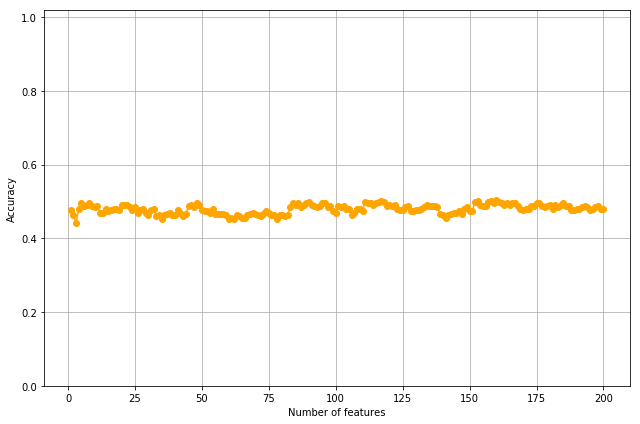

1 feature(s): [202]  Metric Score: 0.5134309649222228  Test Score: 0.47719298245614034
2 feature(s): [62, 202]  Metric Score: 0.5275343748695096  Test Score: 0.4631578947368421
3 feature(s): [62, 92, 202]  Metric Score: 0.5380134854874917  Test Score: 0.4421052631578947
4 feature(s): [62, 92, 201, 202]  Metric Score: 0.5450312679579488  Test Score: 0.4807017543859649
5 feature(s): [14, 62, 92, 201, 202]  Metric Score: 0.5543474292668087  Test Score: 0.49473684210526314
6 feature(s): [14, 62, 92, 103, 201, 202]  Metric Score: 0.5637655966960355  Test Score: 0.48771929824561405
7 feature(s): [14, 62, 67, 92, 103, 201, 202]  Metric Score: 0.5696204298573703  Test Score: 0.49122807017543857
8 feature(s): [14, 62, 67, 92, 103, 110, 201, 202]  Metric Score: 0.5743059109862381  Test Score: 0.49473684210526314
9 feature(s): [14, 62, 67, 92, 103, 110, 201, 202, 247]  Metric Score: 0.5777670005229554  Test Score: 0.48771929824561405
10 feature(s): [14, 62, 67, 92, 103, 110, 201, 202, 247, 347]  

198 feature(s): [0, 1, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 18, 19, 20, 21, 22, 23, 24, 25, 26, 31, 32, 33, 34, 35, 36, 38, 43, 46, 47, 48, 49, 51, 52, 53, 55, 56, 59, 60, 61, 62, 63, 64, 65, 67, 73, 75, 76, 77, 78, 79, 80, 81, 92, 94, 97, 98, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 117, 118, 119, 122, 123, 125, 126, 127, 128, 130, 135, 136, 139, 140, 142, 143, 144, 146, 147, 154, 156, 157, 159, 160, 162, 163, 164, 165, 168, 172, 175, 179, 180, 181, 183, 184, 188, 190, 192, 193, 197, 198, 199, 200, 201, 202, 203, 205, 206, 213, 223, 224, 225, 227, 229, 230, 231, 232, 233, 234, 236, 237, 239, 241, 243, 244, 245, 247, 248, 252, 253, 254, 255, 256, 260, 261, 264, 266, 267, 270, 271, 272, 275, 276, 278, 279, 282, 284, 286, 287, 288, 289, 290, 293, 294, 295, 306, 307, 309, 310, 312, 314, 315, 316, 321, 324, 328, 330, 337, 341, 342, 345, 347, 349, 350, 351, 352, 353, 357, 358, 360, 361, 362, 364, 365]  Metric Score: 0.5346266436804921  Test Score: 0.4877192982

In [179]:
team_pred_model = LogisticRegression(penalty='l2', C=0.07, solver = 'lbfgs', multi_class='multinomial', n_jobs=-1, max_iter = 80000, random_state=20191028)
sfs = SFS(team_pred_model, k_features=200, metric = 'cv')
sfs.fit(X_train_std, y_train)
plotSFS(sfs)
with open('pickle_models/sfs_LogReg_cv.pickle', 'wb') as handle:
    pickle.dump(sfs, handle, protocol=pickle.HIGHEST_PROTOCOL)

Processing: 0
Processing: 1
Processing: 2
Processing: 3
Processing: 4
Processing: 5
Processing: 6
Processing: 7
Processing: 8
Processing: 9
Processing: 10
Processing: 11
Processing: 12
Processing: 13
Processing: 14
Processing: 15
Processing: 16
Processing: 17
Processing: 18
Processing: 19
Processing: 20
Processing: 21
Processing: 22
Processing: 23
Processing: 24
Processing: 25
Processing: 26
Processing: 27
Processing: 28
Processing: 29
Processing: 30
Processing: 31
Processing: 32
Processing: 33
Processing: 34
Processing: 35
Processing: 36
Processing: 37
Processing: 38
Processing: 39
Processing: 40
Processing: 41
Processing: 42
Processing: 43
Processing: 44
Processing: 45
Processing: 46
Processing: 47
Processing: 48
Processing: 49
Processing: 50
Processing: 51
Processing: 52
Processing: 53
Processing: 54
Processing: 55
Processing: 56
Processing: 57
Processing: 58
Processing: 59
Processing: 60
Processing: 61
Processing: 62
Processing: 63
Processing: 64
Processing: 65
Processing: 66
Proce

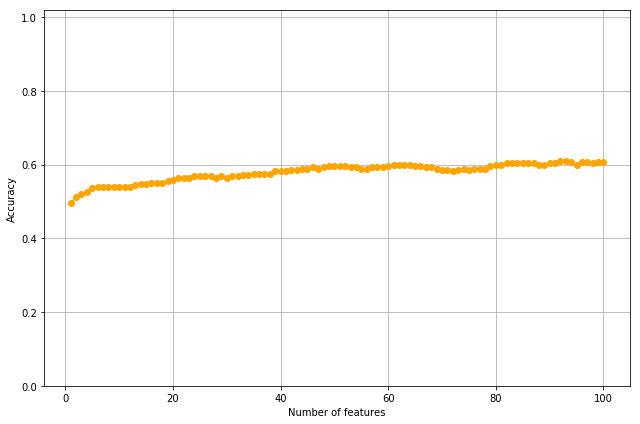

1 feature(s): [302]  Metric Score: 188.91013681713656  Test Score: 0.49473684210526314
2 feature(s): [283, 302]  Metric Score: 193.32936707378096  Test Score: 0.512280701754386
3 feature(s): [123, 283, 302]  Metric Score: 191.80738497474385  Test Score: 0.519298245614035
4 feature(s): [123, 283, 302, 318]  Metric Score: 190.3461478005384  Test Score: 0.5263157894736842
5 feature(s): [123, 252, 283, 302, 318]  Metric Score: 191.09842253810643  Test Score: 0.5368421052631579
6 feature(s): [123, 199, 252, 283, 302, 318]  Metric Score: 187.61324418262532  Test Score: 0.5403508771929825
7 feature(s): [15, 123, 199, 252, 283, 302, 318]  Metric Score: 181.96075500235668  Test Score: 0.5403508771929825
8 feature(s): [15, 36, 123, 199, 252, 283, 302, 318]  Metric Score: 176.308265822088  Test Score: 0.5403508771929825
9 feature(s): [15, 18, 36, 123, 199, 252, 283, 302, 318]  Metric Score: 170.65577664181936  Test Score: 0.5403508771929825
10 feature(s): [15, 18, 30, 36, 123, 199, 252, 283, 302,

In [137]:
team_pred_model = LogisticRegression(penalty='l2', C=0.07, solver = 'lbfgs', multi_class='multinomial', n_jobs=-1, max_iter = 80000, random_state=20191028)
sfs = SFS(team_pred_model, k_features=100, metric = 'bic')
sfs.fit(X_train_std, y_train)
plotSFS(sfs)

41 0.5482933239406551


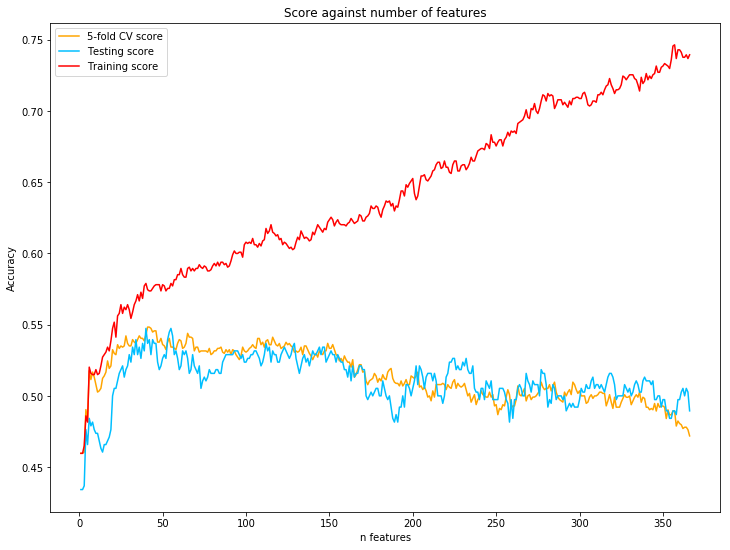

In [241]:
tmp_model = LogisticRegression(penalty='l2', C=0.07, solver = 'lbfgs', multi_class='multinomial', n_jobs=-1, max_iter = 80000, random_state=20191028)
bestK = cvKBestSelector(X, y, tmp_model, RobustScaler())

4 0.5499744896178618


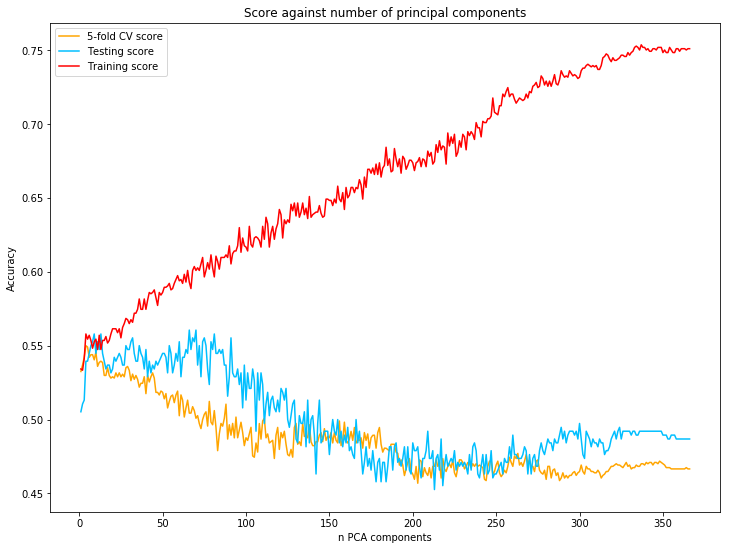

In [242]:
tmp_model = LogisticRegression(penalty='l2', C=0.07, solver = 'lbfgs', multi_class='multinomial', n_jobs=-1, max_iter = 80000, random_state=20191028)
bestK = cvPCA(X, y, tmp_model)

In [49]:
team_pred_model = LogisticRegression(penalty='l2', C=0.07, solver = 'lbfgs', multi_class='multinomial', n_jobs=-1, max_iter = 80000, random_state=20191028)
team_pred_model.fit(X_train_rbs, y_train)
cv_scores = cross_val_score(team_pred_model, X_train_rbs, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print('TRAINING Accuracy: %.3f' % team_pred_model.score(X_train_rbs, y_train))
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('TEST Accuracy: %.3f' % team_pred_model.score(X_test_rbs, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


CV SCORES: [0.54148472 0.56331878 0.51528384 0.56828194 0.55309735]
TRAINING Accuracy: 0.575
Average 5-Fold Training CV Score: 0.5482933239406551
TEST Accuracy: 0.537


In [60]:
log_reg = LogisticRegression(penalty='l2', C=0.0001, solver = 'lbfgs', multi_class='multinomial', verbose = 1, n_jobs=-1, max_iter = 80000, random_state=20191028)
log_reg.fit(X_train, y_train)
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=8, n_jobs=-1)
print("CV SCORES:", cv_scores)
print('TRAINING Accuracy: %.3f' % log_reg.score(X_train, y_train))
print("Average 8-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('TEST Accuracy: %.3f' % log_reg.score(X_test, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


CV SCORES: [0.53472222 0.55555556 0.53472222 0.52447552 0.52112676 0.60283688
 0.56028369 0.56737589]
TRAINING Accuracy: 0.556
Average 8-Fold Training CV Score: 0.5501373423674517
TEST Accuracy: 0.537


In [263]:
log_reg = LogisticRegression(penalty='l2', C=0.0001, solver = 'lbfgs', multi_class='multinomial', verbose = 1, n_jobs=-1, max_iter = 80000, random_state=20191028)
log_reg.fit(X_train_std, y_train)
cv_scores = cross_val_score(log_reg, X_train_std, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print('TRAINING Accuracy: %.3f' % log_reg.score(X_train_std, y_train))
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('TEST Accuracy: %.3f' % log_reg.score(X_test_std, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


CV SCORES: [0.45851528 0.45851528 0.45851528 0.47577093 0.46017699]
TRAINING Accuracy: 0.468
Average 5-Fold Training CV Score: 0.4622987535577917
TEST Accuracy: 0.442


80 0.5421529060130107


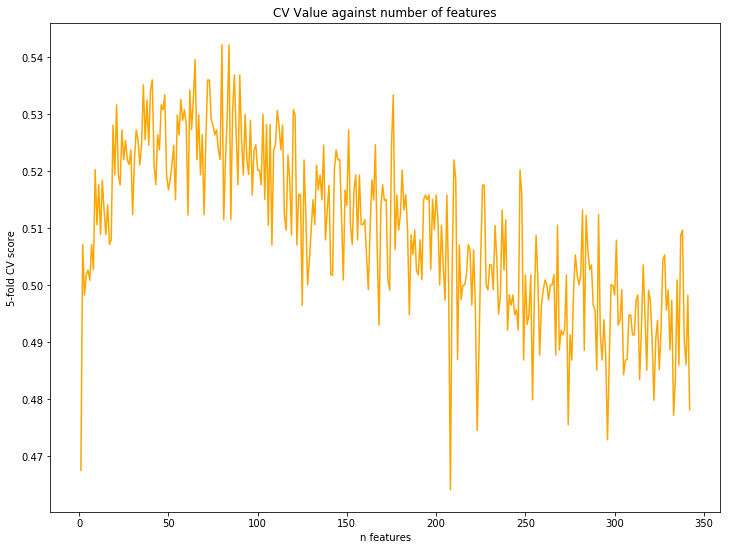

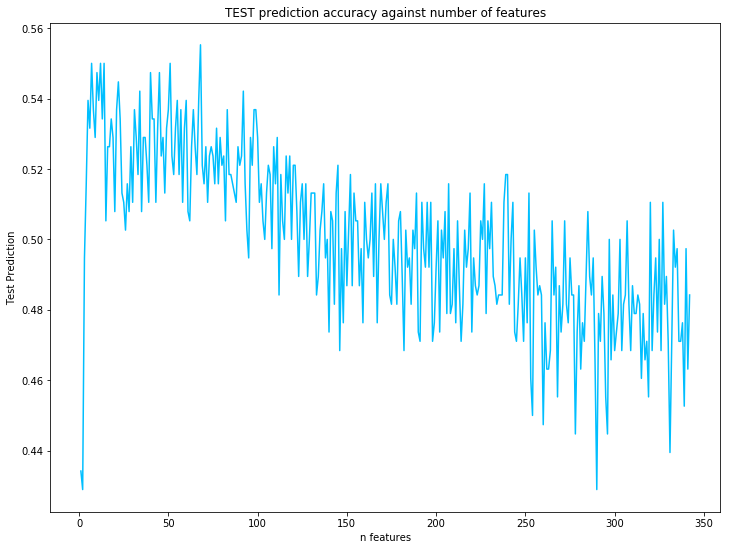

In [88]:
tmp_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=20191027)
bestK = cvPCA(X, y, tmp_model)

Processing: 0
3
Processing: 1
3
Processing: 2
3
Processing: 3
3
Processing: 4
3
Processing: 5
3
Processing: 6
3
Processing: 7
3
Processing: 8
3
Processing: 9
3
Processing: 10
3
Processing: 11
3
Processing: 12
3
Processing: 13
3
Processing: 14
3
Processing: 15
3
Processing: 16
3
Processing: 17
3
Processing: 18
3
Processing: 19
3
Processing: 20
3
Processing: 21
3
Processing: 22
3
Processing: 23
3
Processing: 24
3
Processing: 25
3
Processing: 26
3
Processing: 27
3
Processing: 28
3
Processing: 29
3
Processing: 30
3
Processing: 31
3
Processing: 32
3
Processing: 33
3
Processing: 34
3
Processing: 35
3
Processing: 36
3
Processing: 37
3
Processing: 38
3
Processing: 39
3
Processing: 40
3
Processing: 41
3
Processing: 42
3
Processing: 43
3
Processing: 44
3
Processing: 45
3
Processing: 46
3
Processing: 47
3
Processing: 48
3
Processing: 49
3
Processing: 50
3
Processing: 51
3
Processing: 52
3
Processing: 53
3
Processing: 54
3
Processing: 55
3
Processing: 56
3
Processing: 57
3
Processing: 58
3
Process

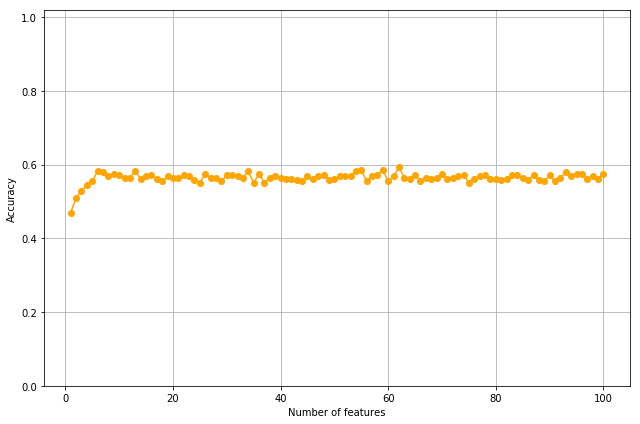

1 feature(s): [320]  Metric Score: 0.47017543859649125  Test Score: 0.47017543859649125
2 feature(s): [120, 320]  Metric Score: 0.5087719298245614  Test Score: 0.5087719298245614
3 feature(s): [120, 267, 320]  Metric Score: 0.5298245614035088  Test Score: 0.5298245614035088
4 feature(s): [120, 156, 267, 320]  Metric Score: 0.543859649122807  Test Score: 0.543859649122807
5 feature(s): [14, 120, 156, 267, 320]  Metric Score: 0.5543859649122806  Test Score: 0.5543859649122806
6 feature(s): [14, 120, 156, 267, 276, 320]  Metric Score: 0.5824561403508772  Test Score: 0.5824561403508772
7 feature(s): [14, 120, 156, 267, 276, 311, 320]  Metric Score: 0.5789473684210527  Test Score: 0.5789473684210527
8 feature(s): [14, 91, 120, 156, 267, 276, 311, 320]  Metric Score: 0.5684210526315789  Test Score: 0.5684210526315789
9 feature(s): [14, 91, 100, 120, 156, 267, 276, 311, 320]  Metric Score: 0.5754385964912281  Test Score: 0.5754385964912281
10 feature(s): [14, 91, 100, 120, 156, 267, 276, 311,

In [154]:
tmp_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=20191027)
sfs = SFS(tmp_model, k_features=100)
sfs.fit(X_train.values, y_train)
plotSFS(sfs)

208 0.5508748350166894


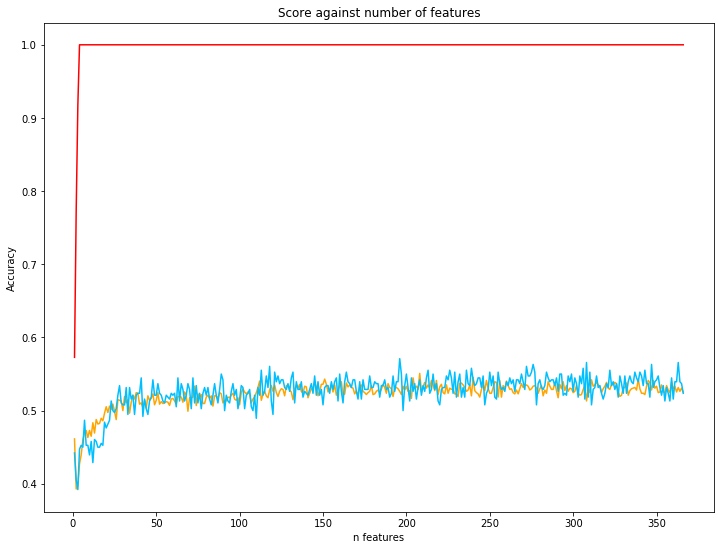

In [234]:
tmp_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=20191027)
bestK = cvKBestSelector(X, y, tmp_model, RobustScaler())

In [61]:
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=20191027)
rfc.fit(X_train, y_train)
# rfFeaturePlot(rfc, X.columns, title="Feature importances")
cv_scores = cross_val_score(rfc, X_train, y_train, cv=10, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 10-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % rfc.score(X_test, y_test))

CV SCORES: [0.54310345 0.54310345 0.51724138 0.46491228 0.53982301 0.52212389
 0.53982301 0.55752212 0.53982301 0.53982301]
Average 10-Fold Training CV Score: 0.5307298609661169
Accuracy: 0.505


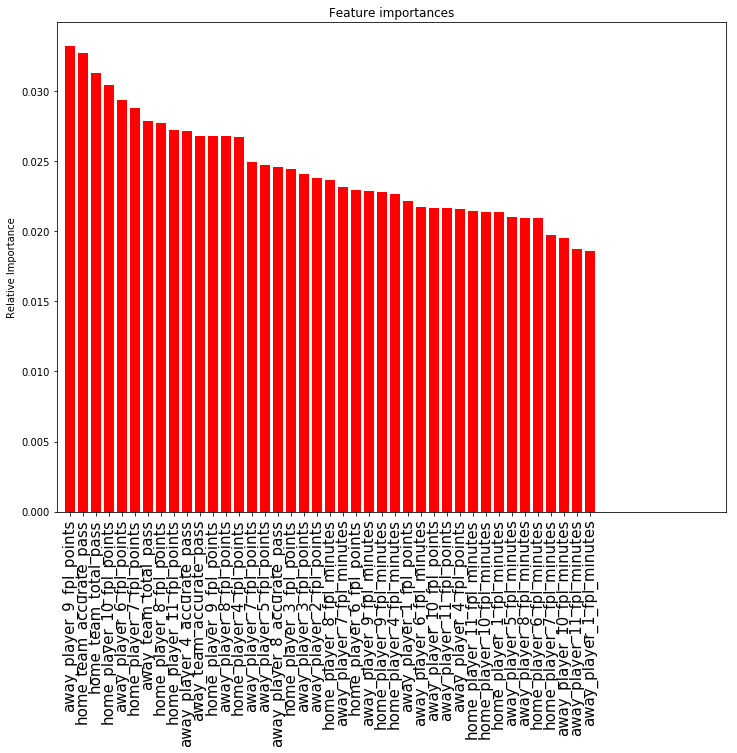

In [38]:
rfFeaturePlot(rfc, X.columns, title="Feature importances")

1 0.5404487580095535


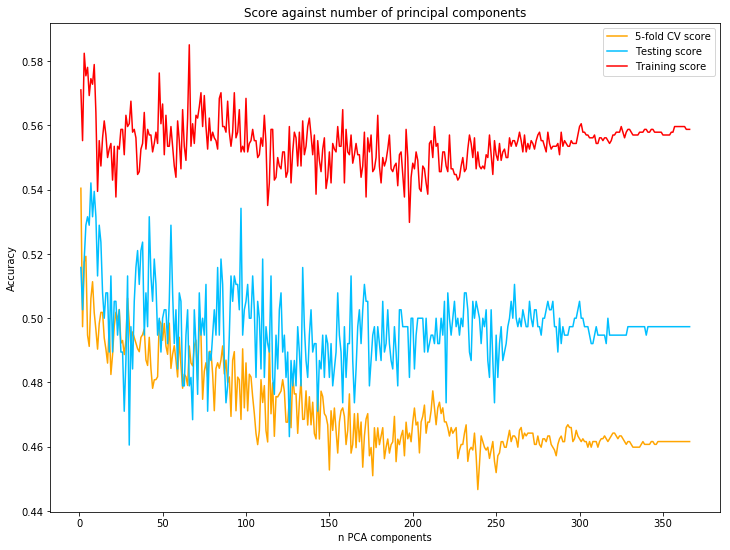

In [205]:
tmp_model = KNeighborsClassifier(n_neighbors = 20, algorithm = 'brute', n_jobs=-1)
bestK = cvPCA(X, y, tmp_model)

In [235]:
estimator = KNeighborsClassifier(n_neighbors = 20, algorithm = 'brute', n_jobs=-1)
selector = RFECV(estimator, step=1, cv=5, verbose = 1)
selector = selector.fit(X_train_std, y_train)
with open('pickle_models/rfecv_KNN.pickle', 'wb') as handle:
    pickle.dump(selector, handle, protocol=pickle.HIGHEST_PROTOCOL)
sum(selector.support_)

Fitting estimator with 366 features.


RuntimeError: The classifier does not expose "coef_" or "feature_importances_" attributes

In [ ]:
f = selector.support_
model = KNeighborsClassifier(n_neighbors = 20, algorithm = 'brute', n_jobs=-1)
model.fit(X_train_std[:, f], y_train)
cv_scores = cross_val_score(model, X_train_std[:, f], y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test_std[:, f], y_test))

Processing: 0
3
Processing: 1
3
Processing: 2
3
Processing: 3
3
Processing: 4
3
Processing: 5
3
Processing: 6
3
Processing: 7
3
Processing: 8
3
Processing: 9
3
Processing: 10
3
Processing: 11
3
Processing: 12
3
Processing: 13
3
Processing: 14
3
Processing: 15
3
Processing: 16
3
Processing: 17
3
Processing: 18
3
Processing: 19
3
Processing: 20
3
Processing: 21
3
Processing: 22
3
Processing: 23
3
Processing: 24
3
Processing: 25
3
Processing: 26
3
Processing: 27
3
Processing: 28
3
Processing: 29
3
Processing: 30
3
Processing: 31
3
Processing: 32
3
Processing: 33
3
Processing: 34
3
Processing: 35
3
Processing: 36
3
Processing: 37
3
Processing: 38
3
Processing: 39
3
Processing: 40
3
Processing: 41
3
Processing: 42
3
Processing: 43
3
Processing: 44
3
Processing: 45
3
Processing: 46
3
Processing: 47
3
Processing: 48
3
Processing: 49
3
Processing: 50
3
Processing: 51
3
Processing: 52
3
Processing: 53
3
Processing: 54
3
Processing: 55
3
Processing: 56
3
Processing: 57
3
Processing: 58
3
Process

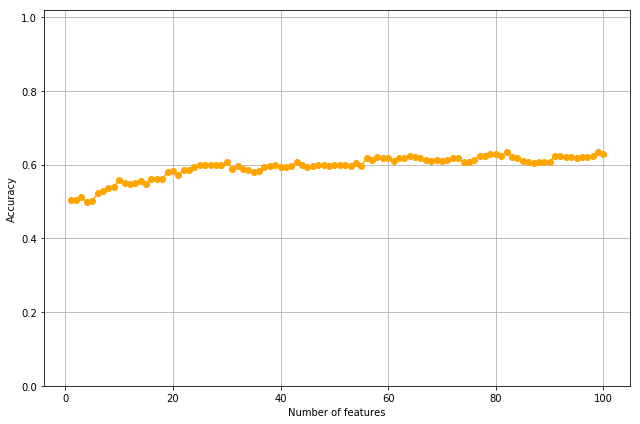

1 feature(s): [302]  Metric Score: 0.5052631578947369  Test Score: 0.5052631578947369
2 feature(s): [91, 302]  Metric Score: 0.5052631578947369  Test Score: 0.5052631578947369
3 feature(s): [91, 96, 302]  Metric Score: 0.512280701754386  Test Score: 0.512280701754386
4 feature(s): [91, 96, 302, 328]  Metric Score: 0.4982456140350877  Test Score: 0.4982456140350877
5 feature(s): [91, 96, 182, 302, 328]  Metric Score: 0.5017543859649123  Test Score: 0.5017543859649123
6 feature(s): [91, 96, 149, 182, 302, 328]  Metric Score: 0.5228070175438596  Test Score: 0.5228070175438596
7 feature(s): [91, 96, 104, 149, 182, 302, 328]  Metric Score: 0.5298245614035088  Test Score: 0.5298245614035088
8 feature(s): [91, 96, 104, 149, 156, 182, 302, 328]  Metric Score: 0.5368421052631579  Test Score: 0.5368421052631579
9 feature(s): [91, 96, 98, 104, 149, 156, 182, 302, 328]  Metric Score: 0.5403508771929825  Test Score: 0.5403508771929825
10 feature(s): [65, 91, 96, 98, 104, 149, 156, 182, 302, 328]  M

In [155]:
tmp_model = KNeighborsClassifier(n_neighbors = 20, algorithm = 'brute', n_jobs=-1)
sfs = SFS(tmp_model, k_features=100)
sfs.fit(X_train_std, y_train)
plotSFS(sfs)

Processing: 0
3
Processing: 1
3
Processing: 2
3
Processing: 3
3
Processing: 4
3
Processing: 5
3
Processing: 6
3
Processing: 7
3
Processing: 8
3
Processing: 9
3
Processing: 10
3
Processing: 11
3
Processing: 12
3
Processing: 13
3
Processing: 14
3
Processing: 15
3
Processing: 16
3
Processing: 17
3
Processing: 18
3
Processing: 19
3
Processing: 20
3
Processing: 21
3
Processing: 22
3
Processing: 23
3
Processing: 24
3
Processing: 25
3
Processing: 26
3
Processing: 27
3
Processing: 28
3
Processing: 29
3
Processing: 30
3
Processing: 31
3
Processing: 32
3
Processing: 33
3
Processing: 34
3
Processing: 35
3
Processing: 36
3
Processing: 37
3
Processing: 38
3
Processing: 39
3
Processing: 40
3
Processing: 41
3
Processing: 42
3
Processing: 43
3
Processing: 44
3
Processing: 45
3
Processing: 46
3
Processing: 47
3
Processing: 48
3
Processing: 49
3
Processing: 50
3
Processing: 51
3
Processing: 52
3
Processing: 53
3
Processing: 54
3
Processing: 55
3
Processing: 56
3
Processing: 57
3
Processing: 58
3
Process

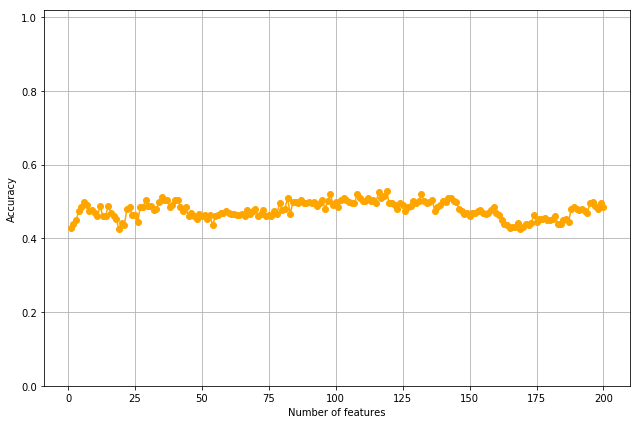

1 feature(s): [202]  Metric Score: 0.49700853630165176  Test Score: 0.4280701754385965
2 feature(s): [202, 302]  Metric Score: 0.5203804251646912  Test Score: 0.43859649122807015
3 feature(s): [134, 202, 302]  Metric Score: 0.5367143689440079  Test Score: 0.44912280701754387
4 feature(s): [10, 134, 202, 302]  Metric Score: 0.5401690557573805  Test Score: 0.47368421052631576
5 feature(s): [10, 134, 202, 240, 302]  Metric Score: 0.5438201590341034  Test Score: 0.4842105263157895
6 feature(s): [10, 134, 202, 240, 302, 360]  Metric Score: 0.550763455164035  Test Score: 0.4982456140350877
7 feature(s): [10, 84, 134, 202, 240, 302, 360]  Metric Score: 0.5484989988288186  Test Score: 0.49122807017543857
8 feature(s): [10, 84, 130, 134, 202, 240, 302, 360]  Metric Score: 0.550797854888837  Test Score: 0.47368421052631576
9 feature(s): [10, 84, 130, 134, 202, 230, 240, 302, 360]  Metric Score: 0.5554083724555637  Test Score: 0.47719298245614034
10 feature(s): [10, 61, 84, 130, 134, 202, 230, 24

In [159]:
tmp_model = KNeighborsClassifier(n_neighbors = 20, algorithm = 'brute', n_jobs=-1)
sfs = SFS(tmp_model, k_features=200, metric = 'cv')
sfs.fit(X_train_std, y_train)
plotSFS(sfs)

In [178]:
# with open('pickle_models/sfs_KNN_20_cv.pickle', 'wb') as handle:
#     pickle.dump(sfs, handle, protocol=pickle.HIGHEST_PROTOCOL)

149 0.5132200128735075


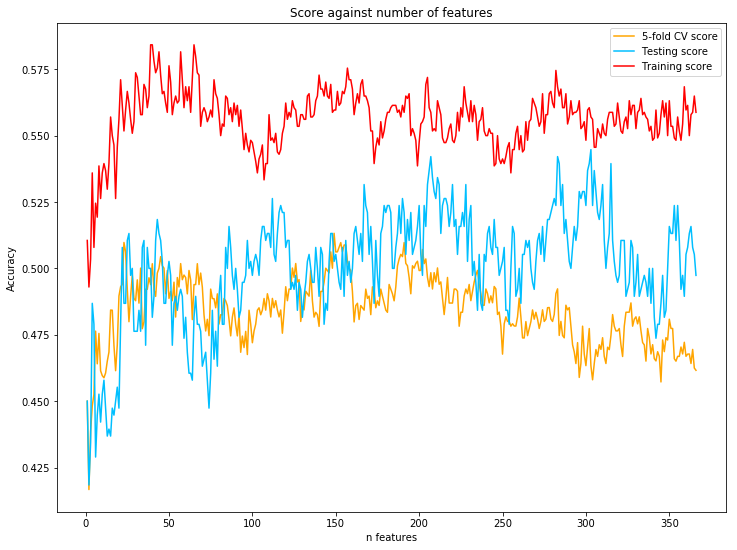

In [237]:
tmp_model = KNeighborsClassifier(n_neighbors = 20, algorithm = 'brute', n_jobs=-1)
bestK = cvKBestSelector(X, y, tmp_model, StandardScaler())

In [63]:
model = GaussianNB()
model.fit(X_train, y_train)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test, y_test))

CV SCORES: [0.40611354 0.48908297 0.42358079 0.48898678 0.44247788]
Average 5-Fold Training CV Score: 0.4500483905647166
Accuracy: 0.489


In [64]:
model = SVC(C=0.01, kernel = 'linear', verbose = 1, max_iter = 50000000, random_state = 20191028)
model.fit(X_train_std, y_train)
cv_scores = cross_val_score(model, X_train_std, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test_std, y_test))

[LibSVM]CV SCORES: [0.46724891 0.51965066 0.47161572 0.52422907 0.45575221]
Average 5-Fold Training CV Score: 0.48769931422440865
Accuracy: 0.479


In [72]:
model = SVC(C=0.001, kernel = 'linear', verbose = 1, max_iter = 50000000, random_state = 20191028)
model.fit(X_train, y_train)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test, y_test))

[LibSVM]CV SCORES: [0.55458515 0.54585153 0.51965066 0.54625551 0.54424779]
Average 5-Fold Training CV Score: 0.542118126092618
Accuracy: 0.547


In [270]:
model = SVC(C=0.5, kernel = 'rbf', verbose = 1, max_iter = 5000000, random_state = 20191028)
model.fit(X_train_std, y_train)
cv_scores = cross_val_score(model, X_train_std, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test_std, y_test))

[LibSVM]CV SCORES: [0.49781659 0.48034934 0.48908297 0.56387665 0.50884956]
Average 5-Fold Training CV Score: 0.5079950235602892
Accuracy: 0.505


In [239]:
estimator = SVC(C=0.5, kernel = 'linear', verbose = 1, max_iter = 5000000,gamma = 'auto', random_state = 20191028)
selector = RFECV(estimator, step=1, cv=5, verbose = 1)
selector = selector.fit(X_train_std, y_train)
with open('pickle_models/rfecv_SVC.pickle', 'wb') as handle:
    pickle.dump(selector, handle, protocol=pickle.HIGHEST_PROTOCOL)
sum(selector.support_)

Fitting estimator with 366 features.
[LibSVM]Fitting estimator with 365 features.
[LibSVM]Fitting estimator with 364 features.
[LibSVM]Fitting estimator with 363 features.
[LibSVM]Fitting estimator with 362 features.
[LibSVM]Fitting estimator with 361 features.
[LibSVM]Fitting estimator with 360 features.
[LibSVM]Fitting estimator with 359 features.
[LibSVM]Fitting estimator with 358 features.
[LibSVM]Fitting estimator with 357 features.
[LibSVM]Fitting estimator with 356 features.
[LibSVM]Fitting estimator with 355 features.
[LibSVM]Fitting estimator with 354 features.
[LibSVM]Fitting estimator with 353 features.
[LibSVM]Fitting estimator with 352 features.
[LibSVM]Fitting estimator with 351 features.
[LibSVM]Fitting estimator with 350 features.
[LibSVM]Fitting estimator with 349 features.
[LibSVM]Fitting estimator with 348 features.
[LibSVM]Fitting estimator with 347 features.
[LibSVM]Fitting estimator with 346 features.
[LibSVM]Fitting estimator with 345 features.
[LibSVM]Fitting es

[LibSVM]Fitting estimator with 183 features.
[LibSVM]Fitting estimator with 182 features.
[LibSVM]Fitting estimator with 181 features.
[LibSVM]Fitting estimator with 180 features.
[LibSVM]Fitting estimator with 179 features.
[LibSVM]Fitting estimator with 178 features.
[LibSVM]Fitting estimator with 177 features.
[LibSVM]Fitting estimator with 176 features.
[LibSVM]Fitting estimator with 175 features.
[LibSVM]Fitting estimator with 174 features.
[LibSVM]Fitting estimator with 173 features.
[LibSVM]Fitting estimator with 172 features.
[LibSVM]Fitting estimator with 171 features.
[LibSVM]Fitting estimator with 170 features.
[LibSVM]Fitting estimator with 169 features.
[LibSVM]Fitting estimator with 168 features.
[LibSVM]Fitting estimator with 167 features.
[LibSVM]Fitting estimator with 166 features.
[LibSVM]Fitting estimator with 165 features.
[LibSVM]Fitting estimator with 164 features.
[LibSVM]Fitting estimator with 163 features.
[LibSVM]Fitting estimator with 162 features.
[LibSVM]Fi

[LibSVM]Fitting estimator with 363 features.
[LibSVM]Fitting estimator with 362 features.
[LibSVM]Fitting estimator with 361 features.
[LibSVM]Fitting estimator with 360 features.
[LibSVM]Fitting estimator with 359 features.
[LibSVM]Fitting estimator with 358 features.
[LibSVM]Fitting estimator with 357 features.
[LibSVM]Fitting estimator with 356 features.
[LibSVM]Fitting estimator with 355 features.
[LibSVM]Fitting estimator with 354 features.
[LibSVM]Fitting estimator with 353 features.
[LibSVM]Fitting estimator with 352 features.
[LibSVM]Fitting estimator with 351 features.
[LibSVM]Fitting estimator with 350 features.
[LibSVM]Fitting estimator with 349 features.
[LibSVM]Fitting estimator with 348 features.
[LibSVM]Fitting estimator with 347 features.
[LibSVM]Fitting estimator with 346 features.
[LibSVM]Fitting estimator with 345 features.
[LibSVM]Fitting estimator with 344 features.
[LibSVM]Fitting estimator with 343 features.
[LibSVM]Fitting estimator with 342 features.
[LibSVM]Fi

[LibSVM]Fitting estimator with 181 features.
[LibSVM]Fitting estimator with 180 features.
[LibSVM]Fitting estimator with 179 features.
[LibSVM]Fitting estimator with 178 features.
[LibSVM]Fitting estimator with 177 features.
[LibSVM]Fitting estimator with 176 features.
[LibSVM]Fitting estimator with 175 features.
[LibSVM]Fitting estimator with 174 features.
[LibSVM]Fitting estimator with 173 features.
[LibSVM]Fitting estimator with 172 features.
[LibSVM]Fitting estimator with 171 features.
[LibSVM]Fitting estimator with 170 features.
[LibSVM]Fitting estimator with 169 features.
[LibSVM]Fitting estimator with 168 features.
[LibSVM]Fitting estimator with 167 features.
[LibSVM]Fitting estimator with 166 features.
[LibSVM]Fitting estimator with 165 features.
[LibSVM]Fitting estimator with 164 features.
[LibSVM]Fitting estimator with 163 features.
[LibSVM]Fitting estimator with 162 features.
[LibSVM]Fitting estimator with 161 features.
[LibSVM]Fitting estimator with 160 features.
[LibSVM]Fi

[LibSVM]Fitting estimator with 361 features.
[LibSVM]Fitting estimator with 360 features.
[LibSVM]Fitting estimator with 359 features.
[LibSVM]Fitting estimator with 358 features.
[LibSVM]Fitting estimator with 357 features.
[LibSVM]Fitting estimator with 356 features.
[LibSVM]Fitting estimator with 355 features.
[LibSVM]Fitting estimator with 354 features.
[LibSVM]Fitting estimator with 353 features.
[LibSVM]Fitting estimator with 352 features.
[LibSVM]Fitting estimator with 351 features.
[LibSVM]Fitting estimator with 350 features.
[LibSVM]Fitting estimator with 349 features.
[LibSVM]Fitting estimator with 348 features.
[LibSVM]Fitting estimator with 347 features.
[LibSVM]Fitting estimator with 346 features.
[LibSVM]Fitting estimator with 345 features.
[LibSVM]Fitting estimator with 344 features.
[LibSVM]Fitting estimator with 343 features.
[LibSVM]Fitting estimator with 342 features.
[LibSVM]Fitting estimator with 341 features.
[LibSVM]Fitting estimator with 340 features.
[LibSVM]Fi

[LibSVM]Fitting estimator with 179 features.
[LibSVM]Fitting estimator with 178 features.
[LibSVM]Fitting estimator with 177 features.
[LibSVM]Fitting estimator with 176 features.
[LibSVM]Fitting estimator with 175 features.
[LibSVM]Fitting estimator with 174 features.
[LibSVM]Fitting estimator with 173 features.
[LibSVM]Fitting estimator with 172 features.
[LibSVM]Fitting estimator with 171 features.
[LibSVM]Fitting estimator with 170 features.
[LibSVM]Fitting estimator with 169 features.
[LibSVM]Fitting estimator with 168 features.
[LibSVM]Fitting estimator with 167 features.
[LibSVM]Fitting estimator with 166 features.
[LibSVM]Fitting estimator with 165 features.
[LibSVM]Fitting estimator with 164 features.
[LibSVM]Fitting estimator with 163 features.
[LibSVM]Fitting estimator with 162 features.
[LibSVM]Fitting estimator with 161 features.
[LibSVM]Fitting estimator with 160 features.
[LibSVM]Fitting estimator with 159 features.
[LibSVM]Fitting estimator with 158 features.
[LibSVM]Fi

[LibSVM]Fitting estimator with 359 features.
[LibSVM]Fitting estimator with 358 features.
[LibSVM]Fitting estimator with 357 features.
[LibSVM]Fitting estimator with 356 features.
[LibSVM]Fitting estimator with 355 features.
[LibSVM]Fitting estimator with 354 features.
[LibSVM]Fitting estimator with 353 features.
[LibSVM]Fitting estimator with 352 features.
[LibSVM]Fitting estimator with 351 features.
[LibSVM]Fitting estimator with 350 features.
[LibSVM]Fitting estimator with 349 features.
[LibSVM]Fitting estimator with 348 features.
[LibSVM]Fitting estimator with 347 features.
[LibSVM]Fitting estimator with 346 features.
[LibSVM]Fitting estimator with 345 features.
[LibSVM]Fitting estimator with 344 features.
[LibSVM]Fitting estimator with 343 features.
[LibSVM]Fitting estimator with 342 features.
[LibSVM]Fitting estimator with 341 features.
[LibSVM]Fitting estimator with 340 features.
[LibSVM]Fitting estimator with 339 features.
[LibSVM]Fitting estimator with 338 features.
[LibSVM]Fi

[LibSVM]Fitting estimator with 177 features.
[LibSVM]Fitting estimator with 176 features.
[LibSVM]Fitting estimator with 175 features.
[LibSVM]Fitting estimator with 174 features.
[LibSVM]Fitting estimator with 173 features.
[LibSVM]Fitting estimator with 172 features.
[LibSVM]Fitting estimator with 171 features.
[LibSVM]Fitting estimator with 170 features.
[LibSVM]Fitting estimator with 169 features.
[LibSVM]Fitting estimator with 168 features.
[LibSVM]Fitting estimator with 167 features.
[LibSVM]Fitting estimator with 166 features.
[LibSVM]Fitting estimator with 165 features.
[LibSVM]Fitting estimator with 164 features.
[LibSVM]Fitting estimator with 163 features.
[LibSVM]Fitting estimator with 162 features.
[LibSVM]Fitting estimator with 161 features.
[LibSVM]Fitting estimator with 160 features.
[LibSVM]Fitting estimator with 159 features.
[LibSVM]Fitting estimator with 158 features.
[LibSVM]Fitting estimator with 157 features.
[LibSVM]Fitting estimator with 156 features.
[LibSVM]Fi

[LibSVM]Fitting estimator with 357 features.
[LibSVM]Fitting estimator with 356 features.
[LibSVM]Fitting estimator with 355 features.
[LibSVM]Fitting estimator with 354 features.
[LibSVM]Fitting estimator with 353 features.
[LibSVM]Fitting estimator with 352 features.
[LibSVM]Fitting estimator with 351 features.
[LibSVM]Fitting estimator with 350 features.
[LibSVM]Fitting estimator with 349 features.
[LibSVM]Fitting estimator with 348 features.
[LibSVM]Fitting estimator with 347 features.
[LibSVM]Fitting estimator with 346 features.
[LibSVM]Fitting estimator with 345 features.
[LibSVM]Fitting estimator with 344 features.
[LibSVM]Fitting estimator with 343 features.
[LibSVM]Fitting estimator with 342 features.
[LibSVM]Fitting estimator with 341 features.
[LibSVM]Fitting estimator with 340 features.
[LibSVM]Fitting estimator with 339 features.
[LibSVM]Fitting estimator with 338 features.
[LibSVM]Fitting estimator with 337 features.
[LibSVM]Fitting estimator with 336 features.
[LibSVM]Fi

[LibSVM]Fitting estimator with 175 features.
[LibSVM]Fitting estimator with 174 features.
[LibSVM]Fitting estimator with 173 features.
[LibSVM]Fitting estimator with 172 features.
[LibSVM]Fitting estimator with 171 features.
[LibSVM]Fitting estimator with 170 features.
[LibSVM]Fitting estimator with 169 features.
[LibSVM]Fitting estimator with 168 features.
[LibSVM]Fitting estimator with 167 features.
[LibSVM]Fitting estimator with 166 features.
[LibSVM]Fitting estimator with 165 features.
[LibSVM]Fitting estimator with 164 features.
[LibSVM]Fitting estimator with 163 features.
[LibSVM]Fitting estimator with 162 features.
[LibSVM]Fitting estimator with 161 features.
[LibSVM]Fitting estimator with 160 features.
[LibSVM]Fitting estimator with 159 features.
[LibSVM]Fitting estimator with 158 features.
[LibSVM]Fitting estimator with 157 features.
[LibSVM]Fitting estimator with 156 features.
[LibSVM]Fitting estimator with 155 features.
[LibSVM]Fitting estimator with 154 features.
[LibSVM]Fi

[LibSVM]Fitting estimator with 355 features.
[LibSVM]Fitting estimator with 354 features.
[LibSVM]Fitting estimator with 353 features.
[LibSVM]Fitting estimator with 352 features.
[LibSVM]Fitting estimator with 351 features.
[LibSVM]Fitting estimator with 350 features.
[LibSVM]Fitting estimator with 349 features.
[LibSVM]Fitting estimator with 348 features.
[LibSVM]Fitting estimator with 347 features.
[LibSVM]Fitting estimator with 346 features.
[LibSVM]Fitting estimator with 345 features.
[LibSVM]Fitting estimator with 344 features.
[LibSVM]Fitting estimator with 343 features.
[LibSVM]Fitting estimator with 342 features.
[LibSVM]Fitting estimator with 341 features.
[LibSVM]Fitting estimator with 340 features.
[LibSVM]Fitting estimator with 339 features.
[LibSVM]Fitting estimator with 338 features.
[LibSVM]Fitting estimator with 337 features.
[LibSVM]Fitting estimator with 336 features.
[LibSVM]Fitting estimator with 335 features.
[LibSVM]Fitting estimator with 334 features.
[LibSVM]Fi

[LibSVM]Fitting estimator with 173 features.
[LibSVM]Fitting estimator with 172 features.
[LibSVM]Fitting estimator with 171 features.
[LibSVM]Fitting estimator with 170 features.
[LibSVM]Fitting estimator with 169 features.
[LibSVM]Fitting estimator with 168 features.
[LibSVM]Fitting estimator with 167 features.
[LibSVM]Fitting estimator with 166 features.
[LibSVM]Fitting estimator with 165 features.
[LibSVM]Fitting estimator with 164 features.
[LibSVM]Fitting estimator with 163 features.
[LibSVM]Fitting estimator with 162 features.
[LibSVM]Fitting estimator with 161 features.
[LibSVM]Fitting estimator with 160 features.
[LibSVM]Fitting estimator with 159 features.
[LibSVM]Fitting estimator with 158 features.
[LibSVM]Fitting estimator with 157 features.
[LibSVM]Fitting estimator with 156 features.
[LibSVM]Fitting estimator with 155 features.
[LibSVM]Fitting estimator with 154 features.
[LibSVM]Fitting estimator with 153 features.
[LibSVM]Fitting estimator with 152 features.
[LibSVM]Fi

8

In [240]:
f = selector.support_
model = SVC(C=0.5, kernel = 'linear', verbose = 1, max_iter = 5000000,gamma = 'auto', random_state = 20191028)
model.fit(X_train_std[:,f], y_train)
cv_scores = cross_val_score(model, X_train_std[:,f], y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test_std[:,f], y_test))

[LibSVM]CV SCORES: [0.53275109 0.52401747 0.52401747 0.55506608 0.52654867]
Average 5-Fold Training CV Score: 0.5324801556124799
Accuracy: 0.534


Processing: 0
3
Processing: 1
3
Processing: 2
3
Processing: 3
3
Processing: 4
3
Processing: 5
3
Processing: 6
3
Processing: 7
3
Processing: 8
3
Processing: 9
3
Processing: 10
3
Processing: 11
3
Processing: 12
3
Processing: 13
3
Processing: 14
3
Processing: 15
3
Processing: 16
3
Processing: 17
3
Processing: 18
3
Processing: 19
3
Processing: 20
3
Processing: 21
3
Processing: 22
3
Processing: 23
3
Processing: 24
3
Processing: 25
3
Processing: 26
3
Processing: 27
3
Processing: 28
3
Processing: 29
3
Processing: 30
3
Processing: 31
3
Processing: 32
3
Processing: 33
3
Processing: 34
3
Processing: 35
3
Processing: 36
3
Processing: 37
3
Processing: 38
3
Processing: 39
3
Processing: 40
3
Processing: 41
3
Processing: 42
3
Processing: 43
3
Processing: 44
3
Processing: 45
3
Processing: 46
3
Processing: 47
3
Processing: 48
3
Processing: 49
3
Processing: 50
3
Processing: 51
3
Processing: 52
3
Processing: 53
3
Processing: 54
3
Processing: 55
3
Processing: 56
3
Processing: 57
3
Processing: 58
3
Process

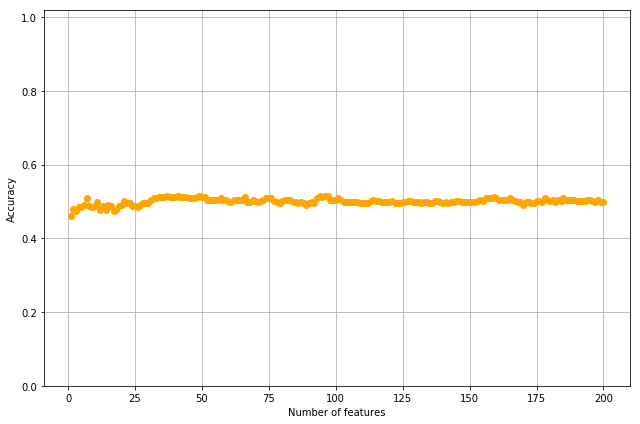

1 feature(s): [202]  Metric Score: 0.5110915450248652  Test Score: 0.45964912280701753
2 feature(s): [103, 202]  Metric Score: 0.5322132146642249  Test Score: 0.4807017543859649
3 feature(s): [103, 201, 202]  Metric Score: 0.5438685572596343  Test Score: 0.47368421052631576
4 feature(s): [103, 153, 201, 202]  Metric Score: 0.5684645991040165  Test Score: 0.4842105263157895
5 feature(s): [103, 153, 201, 202, 322]  Metric Score: 0.5708861011192836  Test Score: 0.4842105263157895
6 feature(s): [103, 147, 153, 201, 202, 322]  Metric Score: 0.5766934904983188  Test Score: 0.49122807017543857
7 feature(s): [20, 103, 147, 153, 201, 202, 322]  Metric Score: 0.5789918693367216  Test Score: 0.5087719298245614
8 feature(s): [20, 103, 147, 153, 201, 202, 322, 339]  Metric Score: 0.5824935227107779  Test Score: 0.48771929824561405
9 feature(s): [20, 103, 147, 153, 188, 201, 202, 322, 339]  Metric Score: 0.5801681013141491  Test Score: 0.4842105263157895
10 feature(s): [13, 20, 103, 147, 153, 188, 2

In [180]:
tmp_model = SVC(C=0.5, kernel = 'rbf', max_iter = 5000000, gamma = 'auto', random_state = 20191028)
sfs = SFS(tmp_model, k_features=200, metric='cv')
sfs.fit(X_train_std, y_train)
plotSFS(sfs)
with open('pickle_models/sfs_SVC_cv.pickle', 'wb') as handle:
    pickle.dump(sfs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
tmp_model = SVC(C=0.5, kernel = 'rbf', max_iter = 5000000, random_state = 20191028)
bestK = cvKBestSelector(X_train_std, y, tmp_model)

In [ ]:
tmp_model = SVC(C=0.5, kernel = 'rbf', max_iter = 5000000, random_state = 20191028)
bestK = cvPCA(X_train_std, y, tmp_model)

In [271]:
model = SVC(C=0.06, kernel = 'sigmoid', verbose = 1, max_iter = 5000000, random_state = 20191028)
model.fit(X_train_std, y_train)
cv_scores = cross_val_score(model, X_train_std, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test_std, y_test))

[LibSVM]CV SCORES: [0.51528384 0.51528384 0.48908297 0.55947137 0.51769912]
Average 5-Fold Training CV Score: 0.5193642271409697
Accuracy: 0.500


In [272]:
model = SVC(C=0.01, kernel = 'linear', verbose = 1, max_iter = 5000000, random_state = 20191028)
model.fit(X_train_rbs, y_train)
cv_scores = cross_val_score(model, X_train_rbs, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test_rbs, y_test))

[LibSVM]CV SCORES: [0.50218341 0.50218341 0.48034934 0.56828194 0.53097345]
Average 5-Fold Training CV Score: 0.516794309371733
Accuracy: 0.487


In [273]:
model = SVC(C=0.08, kernel = 'linear', verbose = 1, max_iter = 5000000, random_state = 20191028)
model.fit(X_train_mm, y_train)
cv_scores = cross_val_score(model, X_train_mm, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test_mm, y_test))

[LibSVM]CV SCORES: [0.48908297 0.51091703 0.48034934 0.55066079 0.52212389]
Average 5-Fold Training CV Score: 0.5106268063470035
Accuracy: 0.489


In [73]:
model = GradientBoostingClassifier(learning_rate = 0.05, random_state = 20191028)
model.fit(X_train, y_train)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test, y_test))

CV SCORES: [0.51965066 0.49781659 0.51528384 0.57709251 0.5       ]
Average 5-Fold Training CV Score: 0.5219687205432546
Accuracy: 0.513


In [74]:
model = GradientBoostingClassifier(learning_rate = 0.005, random_state = 20191028)
model.fit(X_train_mm, y_train)
cv_scores = cross_val_score(model, X_train_mm, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test_mm, y_test))

CV SCORES: [0.48471616 0.50655022 0.50218341 0.51101322 0.49115044]
Average 5-Fold Training CV Score: 0.499122687999259
Accuracy: 0.495


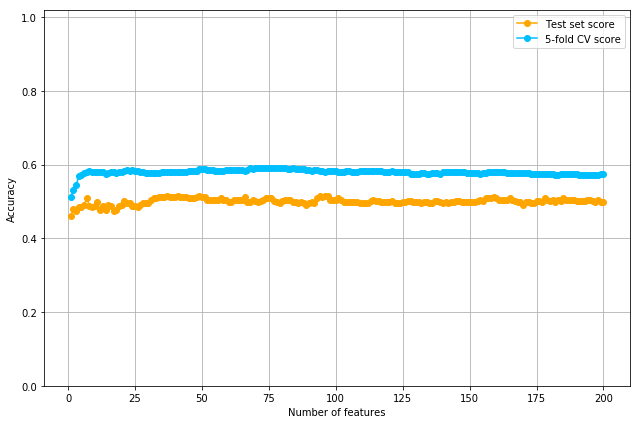

1 feature(s): [202]  Metric Score: 0.5110915450248652  Test Score: 0.45964912280701753
2 feature(s): [103, 202]  Metric Score: 0.5322132146642249  Test Score: 0.4807017543859649
3 feature(s): [103, 201, 202]  Metric Score: 0.5438685572596343  Test Score: 0.47368421052631576
4 feature(s): [103, 153, 201, 202]  Metric Score: 0.5684645991040165  Test Score: 0.4842105263157895
5 feature(s): [103, 153, 201, 202, 322]  Metric Score: 0.5708861011192836  Test Score: 0.4842105263157895
6 feature(s): [103, 147, 153, 201, 202, 322]  Metric Score: 0.5766934904983188  Test Score: 0.49122807017543857
7 feature(s): [20, 103, 147, 153, 201, 202, 322]  Metric Score: 0.5789918693367216  Test Score: 0.5087719298245614
8 feature(s): [20, 103, 147, 153, 201, 202, 322, 339]  Metric Score: 0.5824935227107779  Test Score: 0.48771929824561405
9 feature(s): [20, 103, 147, 153, 188, 201, 202, 322, 339]  Metric Score: 0.5801681013141491  Test Score: 0.4842105263157895
10 feature(s): [13, 20, 103, 147, 153, 188, 2

In [210]:
with open('pickle_models/sfs_SVC_cv.pickle', 'rb') as handle:
    tmp =  pickle.load(handle)   
plotSFS(tmp)

# Doing prediction with goal scorer

team_pred_model : predicting match outcome <br>
goal_scorer_model: predicting chance of scoring

In [34]:
testing_idx_label = []
for idx, row in X_test.iterrows():
    testing_idx_label.append(idx)

In [35]:
master_path = "master_data_ver2/all_season_master_data_each_player_goals.csv"
master_df = pd.read_csv(master_path)
master_df = master_df.loc[testing_idx_label, :]

In [37]:
tmp = "master_data_ver2/all_season_master_data_each_player_goals.csv"
tmp_df = pd.read_csv(master_path)
tmp_df.shape

(1520, 968)

In [142]:
with open('pickle_models/scoring_prob_model.pickle', 'rb') as handle:
    goal_scorer_model =  pickle.load(handle)
with open('pickle_models/scoring_prob_model_stdsc.pickle', 'rb') as handle:
    stdsc_player =  pickle.load(handle)

In [145]:
team_match_col = ['home_team_accurate_pass', 'home_team_total_pass', 'home_player_1_fpl_minutes', 'home_player_3_fpl_points', 'home_player_4_fpl_minutes', 'home_player_4_fpl_points','home_player_6_fpl_minutes', 'home_player_6_fpl_points','home_player_7_fpl_minutes', 'home_player_7_fpl_points','home_player_8_fpl_minutes', 'home_player_8_fpl_points','home_player_9_fpl_minutes', 'home_player_9_fpl_points','home_player_10_fpl_minutes', 'home_player_10_fpl_points','home_player_11_fpl_minutes', 'home_player_11_fpl_points','away_team_accurate_pass', 'away_team_total_pass','away_player_1_fpl_minutes', 'away_player_1_fpl_points','away_player_2_fpl_points', 'away_player_3_fpl_points','away_player_4_fpl_points', 'away_player_4_accurate_pass','away_player_5_fpl_minutes', 'away_player_5_fpl_points','away_player_6_fpl_minutes', 'away_player_6_fpl_points','away_player_7_fpl_minutes', 'away_player_7_fpl_points','away_player_8_fpl_minutes', 'away_player_8_fpl_points','away_player_8_accurate_pass', 'away_player_9_fpl_minutes','away_player_9_fpl_points', 'away_player_10_fpl_minutes','away_player_10_fpl_points', 'away_player_11_fpl_minutes','away_player_11_fpl_points']
goal_scorer_col = ['fpl_minutes', 'fpl_goals', 'fpl_assits', 'fpl_points', 'fpl_bonus', 'formation_place']

In [104]:
X_test

,home_team_accurate_pass,home_team_total_pass,home_player_1_fpl_minutes,home_player_3_fpl_points,home_player_4_fpl_minutes,home_player_4_fpl_points,home_player_6_fpl_minutes,home_player_6_fpl_points,home_player_7_fpl_minutes,home_player_7_fpl_points,...,away_player_7_fpl_points,away_player_8_fpl_minutes,away_player_8_fpl_points,away_player_8_accurate_pass,away_player_9_fpl_minutes,away_player_9_fpl_points,away_player_10_fpl_minutes,away_player_10_fpl_points,away_player_11_fpl_minutes,away_player_11_fpl_points
1472,277.429559,389.299589,1320.25500,37.70000,2257.45300,71.74900,1277.10000,57.30000,1365.00000,41.00000,...,78.36773,2797.89202,101.08639,22.695954,2685.04200,135.10100,609.00000,31.00000,2241.00000,107.00000
1363,278.920781,382.235606,2297.19618,55.33691,2297.28211,96.98171,2358.11848,95.85824,2522.50000,113.40000,...,87.00000,735.00000,25.00000,14.200000,221.00000,16.00000,1779.49800,93.70200,1976.00000,101.00000
301,211.416615,302.043555,2520.00000,95.00000,1255.00000,44.00000,3052.00000,105.00000,2357.00000,58.00000,...,67.00000,3029.00000,103.00000,28.217592,2372.00000,98.00000,1943.00000,71.00000,1419.00000,64.00000
89,252.853673,354.470814,3183.00000,74.00000,2131.00000,64.00000,1382.00000,61.00000,2504.00000,57.00000,...,95.00000,1570.00000,78.00000,58.440000,1879.00000,67.00000,2353.00000,134.00000,2532.00000,216.00000
326,408.993947,513.119786,617.00000,140.00000,3146.00000,142.00000,2186.00000,90.00000,2261.00000,88.00000,...,75.00000,2300.00000,93.00000,41.312812,3132.00000,162.00000,2193.00000,55.00000,2581.00000,191.00000
1011,326.855160,431.411943,1796.10000,35.00000,3420.00000,121.00000,2804.00000,70.00000,2695.00000,77.00000,...,82.86800,1042.00000,55.00000,22.885800,1560.50000,49.30000,1286.75200,70.09800,2320.20000,130.20000
458,210.524070,327.876374,3042.00000,130.90000,2711.00000,150.00000,2568.80000,102.00000,2748.90000,198.60000,...,118.20000,2010.00000,104.20000,26.253239,1761.70000,45.40000,1879.80000,88.50000,1973.00000,155.00000
401,368.377603,447.823856,2256.50000,131.40000,2983.60000,126.40000,2547.00000,142.70000,2639.50000,125.70000,...,108.00000,187.00000,18.00000,6.363636,2748.90000,198.60000,1156.20000,54.90000,2865.40000,183.70000
1074,271.572203,361.025494,1454.40000,77.60000,1330.00000,55.00000,1143.00000,43.00000,1273.00000,34.00000,...,91.00000,1138.00000,40.90000,12.892551,2543.40000,101.90000,2872.00000,130.00000,873.80000,38.10000
624,338.296808,419.908398,3249.90000,92.80000,2200.40000,107.20000,1385.00000,93.50000,1257.40000,47.00000,...,78.20000,2419.60000,74.80000,34.378633,2741.50000,133.10000,2832.50000,73.00000,3080.60000,170.00000


In [105]:
team_pred_model.predict(X_test[:1])

array([1], dtype=int64)

In [161]:
match_prob = team_pred_model.predict_proba(X_test_rbs)

In [202]:
match_prob

array([[0.32712925, 0.26338688, 0.40948387],
       [0.1827774 , 0.3750109 , 0.4422117 ],
       [0.38935641, 0.35098599, 0.2596576 ],
       ...,
       [0.07048653, 0.23675257, 0.69276089],
       [0.64734344, 0.22395047, 0.12870609],
       [0.28951307, 0.27985848, 0.43062844]])

In [203]:
verbose = {}
for outer_i, (idx, row) in enumerate(master_df.iterrows()):
    verbose[idx] = {}
    verbose[idx]['actual'], verbose[idx]['pred_prob'] = {}, {}
    verbose[idx]['actual']['actual_winner'] = row['winner']
    for i in range(1,12):
        player_col = "home_player_"+str(i)+"_match_goal"
        verbose[idx]['actual']['actual_home_player_'+str(i)+'_goal'] = row[player_col]
    for i in range(1,12):    
        player_col = "away_player_"+str(i)+"_match_goal"
        verbose[idx]['actual']['actual_away_player_'+str(i)+'_goal'] = row[player_col]
        
        
    verbose[idx]['pred_prob']['away_win_prob'] = match_prob[outer_i][0]
    verbose[idx]['pred_prob']['draw'] = match_prob[outer_i][1]
    verbose[idx]['pred_prob']['home_win_prob'] = match_prob[outer_i][2]
    
    for i in range(1,12):
        player_col = []
        for p_col in goal_scorer_col:
            player_col.append("home_player_"+str(i)+"_"+p_col)
        loc_player_df = master_df.loc[idx][player_col].astype(float)
        player_X = stdsc_player.transform(loc_player_df.values.reshape(1,-1))
        verbose[idx]['pred_prob']['predicted_home_player_'+str(i)+'_to_score'] = goal_scorer_model.predict_proba(player_X)[0][1]
    for i in range(1,12):
        player_col = []
        for p_col in goal_scorer_col:
            player_col.append("away_player_"+str(i)+"_"+p_col)
        loc_player_df = master_df.loc[idx][player_col].astype(float)
        player_X = stdsc_player.transform(loc_player_df.values.reshape(1,-1))
        verbose[idx]['pred_prob']['predicted_away_player_'+str(i)+'_to_score'] = goal_scorer_model.predict_proba(player_X)[0][1]

In [204]:
with open('verbose_statistic.json', 'w') as fp:
    json.dump(verbose, fp)